## CS3244 Project - Birdwatching SG

### Quick Setup
install the Kaggle API by uncommenting the following line and executing it.

In [1]:
# ! pip install kaggle --upgrade

    100% |████████████████████████████████| 61kB 32.4MB/s 
    100% |████████████████████████████████| 81kB 40.5MB/s 
  Running setup.py bdist_wheel for kaggle ... done
  Stored in directory: /home/jupyter/.cache/pip/wheels/ee/97/c5/87dcdc9434fe4e632ed5945e31a03703af229db178ef6a00e8
  Running setup.py bdist_wheel for python-slugify ... done
  Stored in directory: /home/jupyter/.cache/pip/wheels/16/7f/c3/6b0582283ad589d68a306da924a78c74546e010d8106b9b3a9
Successfully built kaggle python-slugify


Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [3]:
# ! mkdir -p ~/.kaggle/
# ! mv ~/kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.vision import *
bs = 64

In [4]:
Config.DEFAULT_CONFIG = {
        'model_path': '~/.fastai/models'
    }

### 1) Find All Birds 
Single shot multi-box detection (SSD) 

In [42]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
from fastai.vision import *
    
from ssdlib.ssd import build_ssd

In [40]:
net = build_ssd('test', 300, 21)    # initialize SSD
# TODO download model 
net.load_weights('weights/ssd300_mAP_77.43_v2.pth')

Loading weights into state dict...
Finished!


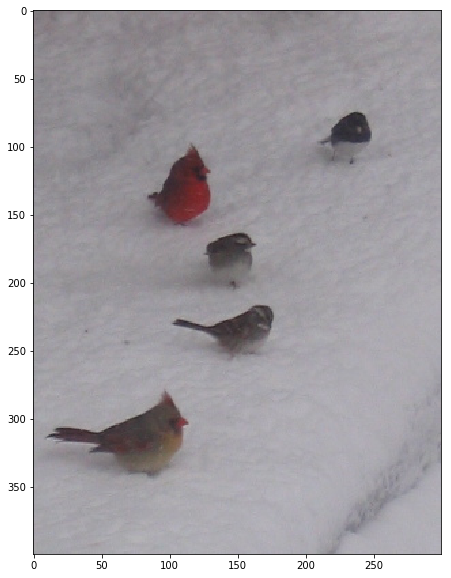

In [55]:
# load a bird image for testing
image = cv2.imread('../data/VOCdevkit/VOC2012/JPEGImages/2008_008347.jpg', cv2.IMREAD_COLOR)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


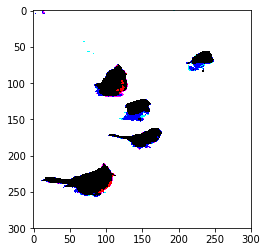

In [56]:
x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

In [58]:
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
y = net(xx)

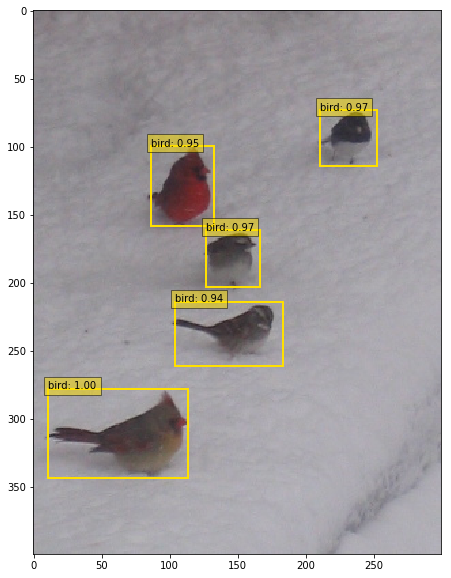

In [62]:
from ssdlib.data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    # only return birds!
    while detections[0,i,j,0] >= 0.6 and labels[i-1] == 'bird':
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

### 2) Export Single Bird Images

In [18]:
#TODO

### 3) Bird Classification

In [5]:
path = Config.data_path()/'birds'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/birds')

In [34]:
#! kaggle datasets download hsankesara/cub200
#! unzip -q -n /home/jupyter/ml-birdwatching/cub200.zip -d {path}

cub200.zip: Skipping, found more recently modified local copy (use --force to force download)


In [14]:
path_annotation = path/'CUB_200_2011'/'CUB_200_2011'
path_img = path/'CUB_200_2011'/'CUB_200_2011'/'images'

import itertools
fnames_raw = [list(subdir.iterdir()) for subdir in list(path_img.iterdir())]
fnames = list(itertools.chain.from_iterable(fnames_raw))
fnames[:5]

[PosixPath('/home/jupyter/.fastai/data/birds/CUB_200_2011/CUB_200_2011/images/029.American_Crow/American_Crow_0039_25061.jpg'),
 PosixPath('/home/jupyter/.fastai/data/birds/CUB_200_2011/CUB_200_2011/images/029.American_Crow/American_Crow_0101_25118.jpg'),
 PosixPath('/home/jupyter/.fastai/data/birds/CUB_200_2011/CUB_200_2011/images/029.American_Crow/American_Crow_0109_25123.jpg'),
 PosixPath('/home/jupyter/.fastai/data/birds/CUB_200_2011/CUB_200_2011/images/029.American_Crow/American_Crow_0134_25206.jpg'),
 PosixPath('/home/jupyter/.fastai/data/birds/CUB_200_2011/CUB_200_2011/images/029.American_Crow/American_Crow_0050_25255.jpg')]

In [15]:
np.random.seed(100)
pat = r'/([^/]+)_\d+_\d+.jpg$'

In [16]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                   ).normalize(imagenet_stats)

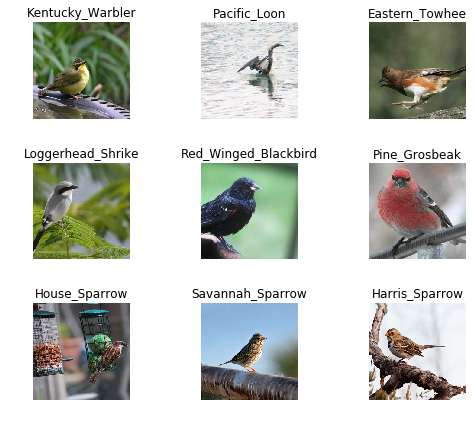

In [17]:
data.show_batch(rows=3, figsize=(7,6))

In [39]:
print(data.classes)
len(data.classes),data.c

['Acadian_Flycatcher', 'American_Crow', 'American_Goldfinch', 'American_Pipit', 'American_Redstart', 'American_Three_Toed_Woodpecker', 'Anna_Hummingbird', 'Artic_Tern', 'Baird_Sparrow', 'Baltimore_Oriole', 'Bank_Swallow', 'Barn_Swallow', 'Bay_Breasted_Warbler', 'Belted_Kingfisher', 'Bewick_Wren', 'Black_And_White_Warbler', 'Black_Billed_Cuckoo', 'Black_Capped_Vireo', 'Black_Footed_Albatross', 'Black_Tern', 'Black_Throated_Blue_Warbler', 'Black_Throated_Sparrow', 'Blue_Grosbeak', 'Blue_Headed_Vireo', 'Blue_Jay', 'Blue_Winged_Warbler', 'Boat_Tailed_Grackle', 'Bobolink', 'Bohemian_Waxwing', 'Brandt_Cormorant', 'Brewer_Blackbird', 'Brewer_Sparrow', 'Bronzed_Cowbird', 'Brown_Creeper', 'Brown_Pelican', 'Brown_Thrasher', 'Cactus_Wren', 'California_Gull', 'Canada_Warbler', 'Cape_Glossy_Starling', 'Cape_May_Warbler', 'Cardinal', 'Carolina_Wren', 'Caspian_Tern', 'Cedar_Waxwing', 'Cerulean_Warbler', 'Chestnut_Sided_Warbler', 'Chipping_Sparrow', 'Chuck_Will_Widow', 'Clark_Nutcracker', 'Clay_Colore

(200, 200)

In [18]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


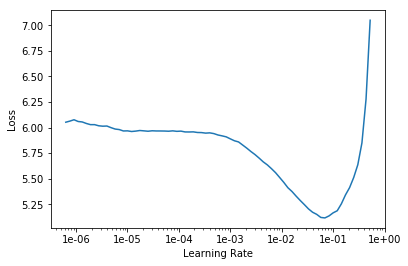

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,4.224281,2.854556,0.606279,01:38
1,2.255412,1.473420,0.397115,01:35
2,1.553021,1.181664,0.323292,01:35
3,1.254111,1.099659,0.312686,01:35
4,1.016266,0.975405,0.280017,01:35
5,0.832221,0.896377,0.244378,01:35
6,0.670979,0.874155,0.238439,01:36
7,0.545306,0.839197,0.230378,01:35
8,0.481496,0.831285,0.228681,01:35
9,0.424285,0.827657,0.231650,01:35


In [ ]:
# learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-3))

In [22]:
learn.save('bird-resnet')